In [1]:
import os
import matplotlib.pyplot as plt 

In [6]:
song_names = [i[:-4] for i in os.listdir('../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_duration/')]
len(song_names)

841

In [3]:
lyrics_prefix = '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_duration/'
durations_prefix = '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_duration/'
pitches_prefix = '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/'

name_features = {name: {'lyrics':None, 'pitches':None, 'durations': None} for name in song_names[:50]} # 歌曲名：[lyrics], [pitch], [duration]
lyrics_50 = [] # [[[第一首歌曲第一句], [第一首歌曲第二句], ...], [[第二首歌曲第一句], [第二首歌曲第二句]...]...]
pitches_50 = []
durations_50 = []

for id_song in range(50):
    cur_name = song_names[id_song]
    with open(lyrics_prefix + cur_name + '.txt', 'r') as f:
        
        #lyrics
        lines = [i for i in f.read().split('\n') if i !=''] # 奇数序列是duration，偶数序列是汉字
        lyrics = [value.rstrip().replace('\u3000', '').split(' ') for i, value in enumerate(lines) if i % 2 == 0] # 歌词之间的空格去掉
        lyrics_50.append(lyrics) # 存入歌词句子组成的列表
        name_features[cur_name]['lyrics'] = lyrics
    
    # try:
        # durations
        # print(lines)
        durations = [[float(j) for j in value.rstrip().replace('\u3000', '').split(' ') if j != ''] for i, value in enumerate(lines) if i % 2 != 0] # duration float format
        durations_50.append(durations)
        name_features[cur_name]['durations'] = durations
    # except Exception as e:
    #     print(e)
    #     print(lines)
    #     break

    with open(pitches_prefix + cur_name + '.txt', 'r') as f:
        lines = [i for i in f.read().split('\n') if i !=''] # 奇数序列是pitch，偶数序列是汉字
        pitches = [value.rstrip().replace('\u3000', '').split(' ') for i, value in enumerate(lines) if i % 2 != 0]  # pitch float format
        # 因为pitch存在一个字对应多个pitch的情况，所以取均值
        for i in range(len(pitches)):
            for j in range(len(pitches[i])):
                lst = pitches[i][j].split(',')
                pitches[i][j] = sum([float(v) for v in lst]) / len(lst)
                
        pitches_50.append(pitches) # 存入歌词句子组成的列表
        name_features[cur_name]['pitches'] = pitches
    
        
len(name_features), len(lyrics_50), len(pitches_50), len(durations_50)

(50, 50, 50, 50)

In [4]:
# 只保留句子长度在三个元素上对应相等的句子
name_features_equal = {name: {'lyrics':[], 'pitches':[], 'durations': []} for name in song_names[:50]} 
lyrics_50_equal = [] # [[[第一首歌曲第一句], [第一首歌曲第二句], ...], [[第二首歌曲第一句], [第二首歌曲第二句]...]...]
pitches_50_equal = []
durations_50_equal = []

# 检查字、pitch、duration每个句子所含元素数目是否相同，所含句子数目是否相同，并且记录句长分布
song_lengths = []
length_records = []
delete_count = 0
for i in name_features:
    if len(name_features[i]['lyrics']) == len(name_features[i]['pitches']) and \
        len(name_features[i]['durations']) == len(name_features[i]['pitches']):
            song_lengths.append(len(name_features[i]['durations']))
            cur_l = []
            cur_d = []
            cur_p = []
            for j in range(len(name_features[i]['lyrics'])):
                if (len(name_features[i]['lyrics'][j]) == len(name_features[i]['pitches'][j]) and \
                        len(name_features[i]['durations'][j]) == len(name_features[i]['pitches'][j])) :
                    cur_l.append(name_features[i]['lyrics'][j])
                    cur_p.append(name_features[i]['pitches'][j])
                    cur_d.append(name_features[i]['durations'][j])
                    name_features_equal[i]['lyrics'].append(name_features[i]['lyrics'][j])
                    name_features_equal[i]['pitches'].append(name_features[i]['pitches'][j])
                    name_features_equal[i]['durations'].append(name_features[i]['durations'][j])
                else:
                    delete_count += 1
                length_records.append(len(name_features[i]['durations'][j]))
            lyrics_50_equal.append(cur_l)
            durations_50_equal.append(cur_d)
            pitches_50_equal.append(cur_p)
    else:
        print(i)

上弦月


In [5]:
delete_count,len(length_records),len(song_lengths)

(36, 1351, 49)

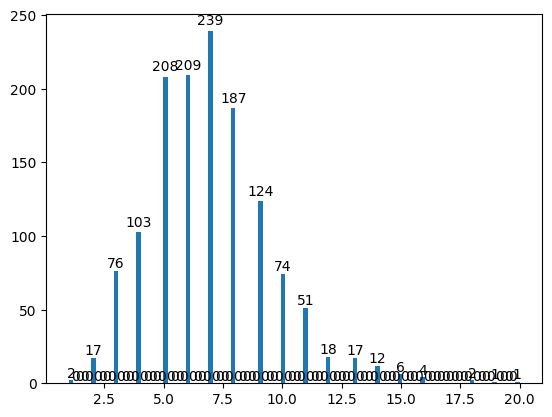

In [6]:
n, bins,_ = plt.hist(length_records, bins=100)
for i in range(len(n)):
    plt.text(bins[i]+(bins[1]-bins[0])/2, n[i]*1.01, int(n[i]), ha='center', va= 'bottom')

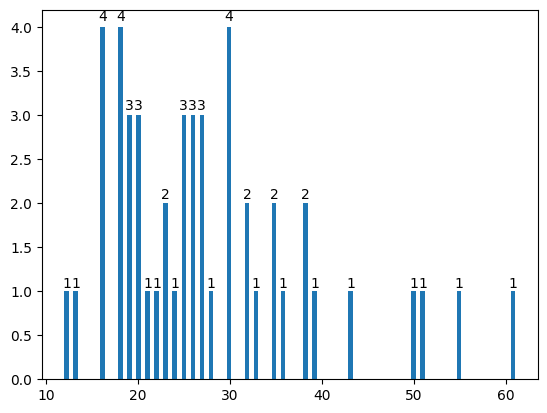

In [7]:
n, bins,_ = plt.hist(song_lengths, bins=100)
for i in range(len(n)):
    if n[i] > 0:
        plt.text(bins[i]+(bins[1]-bins[0])/2, n[i]*1.01, int(n[i]), ha='center', va='bottom')

In [8]:
def process_strings(input_list):
    result_list = []

    for sublist in input_list:
        sentence = ""
        for i, s in enumerate(sublist):
            if i > 0:
                # 如果前一个字符串是中文，当前字符串是英文，加一个空格
                if sublist[i-1].encode("utf-8").isalpha() and s.encode("utf-8").isalpha():
                    sentence += " "
            sentence += s

        result_list.append(sentence)

    return result_list

In [9]:
import copy

# 把所有的pitch和duration进行PAD操作，lyrics每一行进行联合
max_legnth = max(length_records)
PAD = 0
pitches_PAD = []
duration_PAD = []
lyrics_all = []

for i in range(49):
    for j in range(len(lyrics_50_equal[i])):
        ori_pitches = copy.deepcopy(pitches_50_equal[i][j])
        ori_durations = copy.deepcopy(durations_50_equal[i][j])
        while len(ori_pitches) < max_legnth:
            ori_pitches.append(PAD)
            ori_durations.append(PAD)
        assert len(ori_pitches) == len(ori_durations) ,(i,j)
        lyrics_all.append(lyrics_50_equal[i][j])
        pitches_PAD.append(ori_pitches)
        duration_PAD.append(ori_durations)
lyrics_all = process_strings(lyrics_all)

In [10]:
len(pitches_PAD),len(duration_PAD), len(lyrics_all)

(1315, 1315, 1315)

In [13]:
import json

with open('./data_test_49/name_features_equal.dict', 'w') as f:
    f.write(json.dumps(name_features_equal))
with open('./data_test_49/pitches_PAD_equal_1315.lst', 'w') as f:
    f.write(json.dumps(pitches_PAD))
with open('./data_test_49/durations_PAD_equal_1315.lst', 'w') as f:
    f.write(json.dumps(duration_PAD))
with open('./data_test_49/lyrics_equal_1315.lst', 'w') as f:
    f.write(json.dumps(lyrics_all))

In [12]:
import copy
# 生成用来测模型的train data
max_legnth = max(length_records)
PAD = 0
pitches_PAD = []
duration_PAD = []
lyrics_all = []

for i in range(1):
    for j in range(len(lyrics_50_equal[i])):
        ori_pitches = copy.deepcopy(pitches_50_equal[i][j])
        ori_durations = copy.deepcopy(durations_50_equal[i][j])
        while len(ori_pitches) < max_legnth:
            ori_pitches.append(PAD)
            ori_durations.append(PAD)
        assert len(ori_pitches) == len(ori_durations) ,(i,j)
        lyrics_all.append(lyrics_50_equal[i][j])
        pitches_PAD.append(ori_pitches)
        duration_PAD.append(ori_durations)
lyrics_all = process_strings(lyrics_all)
len(pitches_PAD),len(duration_PAD), len(lyrics_all)

(61, 61, 61)

In [18]:
import json

with open('./data_test_1/name_features_equal.dict', 'w') as f:
    f.write(json.dumps(name_features_equal))
with open('./data_test_1/pitches_PAD_equal_61.lst', 'w') as f:
    f.write(json.dumps(pitches_PAD))
with open('./data_test_1/durations_PAD_equal_61.lst', 'w') as f:
    f.write(json.dumps(duration_PAD))
with open('./data_test_1/lyrics_equal_61.lst', 'w') as f:
    f.write(json.dumps(lyrics_all))

In [13]:
import copy
# 生成用来测模型的test data
max_legnth = max(length_records)
PAD = 0
pitches_PAD = []
duration_PAD = []
lyrics_all = []

for i in range(1,2):
    for j in range(len(lyrics_50_equal[i])):
        ori_pitches = copy.deepcopy(pitches_50_equal[i][j])
        ori_durations = copy.deepcopy(durations_50_equal[i][j])
        while len(ori_pitches) < max_legnth:
            ori_pitches.append(PAD)
            ori_durations.append(PAD)
        assert len(ori_pitches) == len(ori_durations) ,(i,j)
        lyrics_all.append(lyrics_50_equal[i][j])
        pitches_PAD.append(ori_pitches)
        duration_PAD.append(ori_durations)
lyrics_all = process_strings(lyrics_all)
len(pitches_PAD),len(duration_PAD), len(lyrics_all)

(55, 55, 55)

In [14]:
import json

with open('./data_test_1/test_model/name_features_equal.dict', 'w') as f:
    f.write(json.dumps(name_features_equal))
with open('./data_test_1/test_model/pitches_PAD_equal_55.lst', 'w') as f:
    f.write(json.dumps(pitches_PAD))
with open('./data_test_1/test_model/durations_PAD_equal_55.lst', 'w') as f:
    f.write(json.dumps(duration_PAD))
with open('./data_test_1/test_model/lyrics_equal_55.lst', 'w') as f:
    f.write(json.dumps(lyrics_all))

In [7]:
# 看一下所有歌曲duration的分布情况
lyrics_prefix = '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_duration/'
durations_prefix = '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_duration/'
pitches_prefix = '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/'

name_features = {name: {'lyrics':None, 'pitches':None, 'durations': None} for name in song_names} # 歌曲名：[lyrics], [pitch], [duration]
lyrics_all = [] # [[[第一首歌曲第一句], [第一首歌曲第二句], ...], [[第二首歌曲第一句], [第二首歌曲第二句]...]...]
pitches_all = []
durations_all = []

for id_song in range(len(name_features)):
    try:
        cur_name = song_names[id_song]
        
        with open(lyrics_prefix + cur_name + '.txt', 'r') as f:
            
            #lyrics
            lines = [i for i in f.read().split('\n') if i !=''] # 奇数序列是duration，偶数序列是汉字
            lyrics = [value.rstrip().replace('\u3000', '').split(' ') for i, value in enumerate(lines) if i % 2 == 0] # 歌词之间的空格去掉
            lyrics_all.append(lyrics) # 存入歌词句子组成的列表
            name_features[cur_name]['lyrics'] = lyrics
        
        # try:
            # durations
            # print(lines)
            durations = [[float(j) for j in value.rstrip().replace('\u3000', '').split(' ') if j != ''] for i, value in enumerate(lines) if i % 2 != 0] # duration float format
            durations_all.append(durations)
            name_features[cur_name]['durations'] = durations
        # except Exception as e:
        #     print(e)
        #     print(lines)
        #     break

        with open(pitches_prefix + cur_name + '.txt', 'r') as f:
            lines = [i for i in f.read().split('\n') if i !=''] # 奇数序列是pitch，偶数序列是汉字
            pitches = [value.rstrip().replace('\u3000', '').split(' ') for i, value in enumerate(lines) if i % 2 != 0]  # pitch float format
            # 因为pitch存在一个字对应多个pitch的情况，所以取均值
            for i in range(len(pitches)):
                for j in range(len(pitches[i])):
                    lst = pitches[i][j].split(',')
                    pitches[i][j] = sum([float(v) for v in lst]) / len(lst)
                    
            pitches_all.append(pitches) # 存入歌词句子组成的列表
            name_features[cur_name]['pitches'] = pitches
    except Exception as e:
        print(e, cur_name)
        continue
        
len(name_features), len(lyrics_all), len(pitches_all), len(durations_all)

[Errno 2] No such file or directory: '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/但願人長久.txt' 但願人長久
[Errno 2] No such file or directory: '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/健康歌.txt' 健康歌
[Errno 2] No such file or directory: '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/分享.txt' 分享
[Errno 2] No such file or directory: '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/分手快樂.txt' 分手快樂
could not convert string to float: '0.20.5' 勇氣
[Errno 2] No such file or directory: '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/天才白癡往日情.txt' 天才白癡往日情
[Errno 2] No such file or directory: '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/天黑黑.txt' 天黑黑
[Errno 2] No such file or directory: '../reproduction/conditional_diffusion/data/iComposer_data/dataset/lyrics_note/安靜.txt' 安靜
[Errno 2] No such file or directory: '..

(841, 841, 830, 840)

In [8]:
duration_set = []

for i in durations_all:
    for j in i:
        for k in j:
            duration_set.append(k)
len(set(duration_set)), len([])

(48, 0)

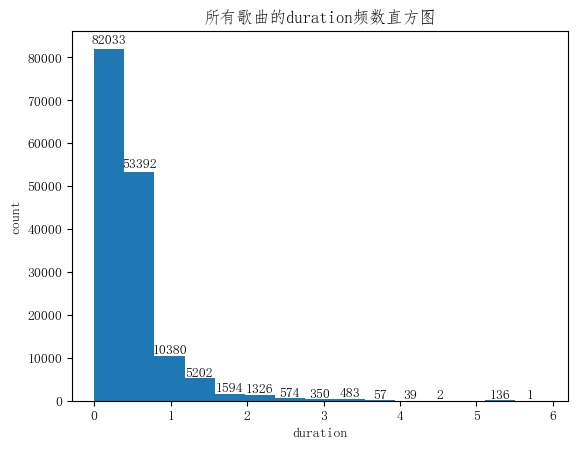

<Figure size 2000x1000 with 0 Axes>

In [21]:
import matplotlib

n, bins,_ = plt.hist(duration_set,bins=15)
for i in range(len(n)):
    if n[i] > 0:
        plt.text(bins[i]+(bins[1]-bins[0])/2, n[i]*1.01, int(n[i]), ha='center', va='bottom')
plt.xlabel('duration')
plt.ylabel('count')
plt.title('所有歌曲的duration频数直方图')
matplotlib.rc("font",family='FangSong')
plt.figure(figsize=(20,10))
plt.show()

In [20]:
for id, number in enumerate(sorted(list(set(duration_set)))):
    if id == 0 or id % 10 != 0:
        print(number, duration_set.count(number), end='\t')
    else:
        print(number)

0.0 428	0.1 5982	0.2 46756	0.25 20	0.3 28847	0.4 28379	0.5 14252	0.6 6756	0.7 3999	0.75 6	0.8
0.9 2842	1.0 1972	1.1 1456	1.2 1532	1.3 1671	1.4 735	1.5 1264	1.6 367	1.7 551	1.75
1.8 470	1.9 205	2.0 366	2.1 249	2.2 214	2.3 497	2.4 208	2.5 106	2.6 175	2.7
2.8 94	2.9 51	3.0 184	3.1 21	3.2 103	3.3 37	3.4 303	3.5 40	3.6 50	3.64
3.8 2	3.9 4	4.0 33	4.1 6	4.6 2	5.3 136	5.9 1	

In [24]:
for i in set(duration_set):
    if i * 100 % 10 != 0:
        print(i)
0.5 % 0.1

4.1
4.6
0.25
0.75
1.75
1.1
2.2
2.3
3.64


0.09999999999999998

In [29]:
{float(number): float(id + 1) for id, number in enumerate(sorted(list(set(duration_set))))}

{0.0: 1.0,
 0.1: 2.0,
 0.2: 3.0,
 0.25: 4.0,
 0.3: 5.0,
 0.4: 6.0,
 0.5: 7.0,
 0.6: 8.0,
 0.7: 9.0,
 0.75: 10.0,
 0.8: 11.0,
 0.9: 12.0,
 1.0: 13.0,
 1.1: 14.0,
 1.2: 15.0,
 1.3: 16.0,
 1.4: 17.0,
 1.5: 18.0,
 1.6: 19.0,
 1.7: 20.0,
 1.75: 21.0,
 1.8: 22.0,
 1.9: 23.0,
 2.0: 24.0,
 2.1: 25.0,
 2.2: 26.0,
 2.3: 27.0,
 2.4: 28.0,
 2.5: 29.0,
 2.6: 30.0,
 2.7: 31.0,
 2.8: 32.0,
 2.9: 33.0,
 3.0: 34.0,
 3.1: 35.0,
 3.2: 36.0,
 3.3: 37.0,
 3.4: 38.0,
 3.5: 39.0,
 3.6: 40.0,
 3.64: 41.0,
 3.8: 42.0,
 3.9: 43.0,
 4.0: 44.0,
 4.1: 45.0,
 4.6: 46.0,
 5.3: 47.0,
 5.9: 48.0}

In [28]:
import json
with open('./duration_vocab.dict', 'w') as f:
    f.write(json.dumps({float(number): float(id + 1) for id, number in enumerate(sorted(list(set(duration_set))))}))